In [39]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [40]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

In [41]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

In [42]:
def abs_residual(params,data):
    x = data['x']
    y = data['y']
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'])
    
    y0 = [x[0], y[0]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

In [43]:
def loss_function_res(params, data):
    t_data = np.array(data['t'], dtype=float)
    x = np.array(data['x'], dtype=float)
    y = np.array(data['y'], dtype=float)
    y0 = [x[0], y[0]]
    t = np.linspace(t_data[0], t_data[-1], num=len(t_data))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = output[i,0]

        y_data = y[i]
        y_model = output[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [89]:
def hill_climber(data, initial_params, step_size, iterations):
    best_params = initial_params
    prev_params = best_params*2
    best_loss = loss_function_res(initial_params, data)
    
    while best_params.any != prev_params.any:
        prev_params = best_params
        for i in range(iterations):
            init_par = initial_params
            # Generate a random perturbation to the parameters
            new_params = []
            for param in init_par:
                new_param = param + np.random.normal(0,step_size)
                new_params.append(new_param)
            
            new_params = np.array(new_params)
            # Calculate the loss for the new parameters
            new_loss = loss_function_res(new_params, data)
            
            # Update if the new parameters give a better loss
            if new_loss < best_loss:
                best_loss = new_loss
                best_params = new_params
    
    return best_params, best_loss

In [102]:
init_guess = []
for i in range(4):
    init_guess.append(random.uniform(0, 5))
  
init_guess = np.array(init_guess)
step_size = 0.5
iterations = 10
data = df

params, loss = hill_climber(data, init_guess, step_size, iterations)
print(params, loss)

[3.47706427 1.67740948 1.11540682 3.53641009] 899.1330260599265


[ 1.75263074e+00  2.89877897e+00 -1.83009905e-01 -2.38153065e-03
  3.48822603e+00  2.29158909e+00] 983.1656982234076


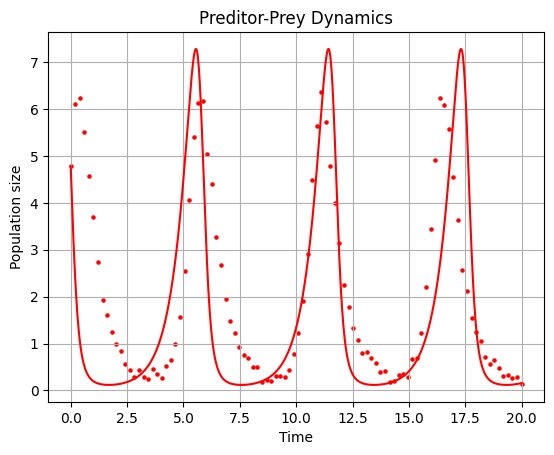

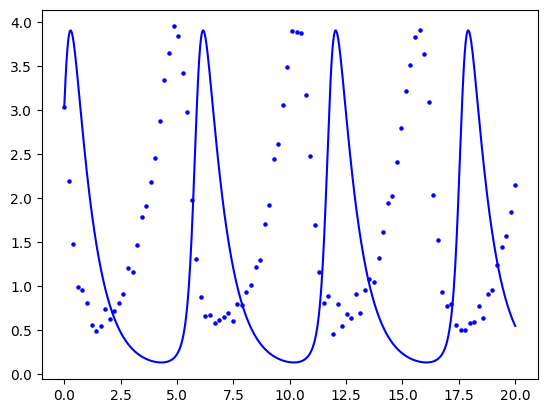

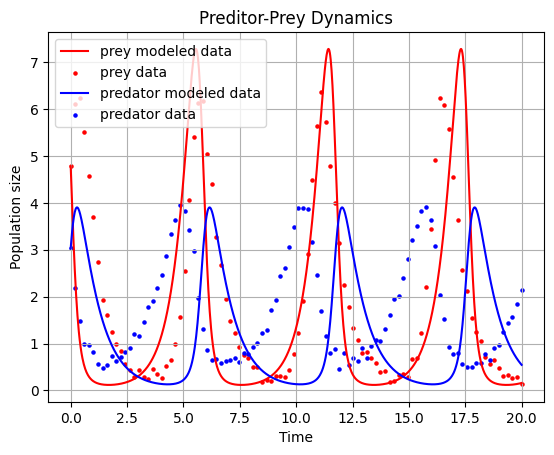

In [247]:
init_guess = []
for i in range(6):
    init_guess.append(random.uniform(0, 5))
  
init_guess = np.array(init_guess)
step_size = 0.5
iterations = 10
data = df

params, loss = hill_climber(data, init_guess, step_size, iterations)
print(params, loss)

alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

alpha_sim = 1.59747957
beta_sim = 1.44338294
delta_sim = 0.66075559
gamma_sim = 1.14532137

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'prey')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'predator')

plt.show()

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()
plt.plot(t,output[:,0], color="r", label = 'prey modeled data')
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'prey data')
plt.plot(t,output[:,1], color="b", label = 'predator modeled data')
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'predator data')
plt.legend()

plt.show()

In [29]:
def multirun_hill(n_runs, data, init_guess, step_size, iterations):
    params, loss = hill_climber(data, init_guess, step_size, iterations)
    best_par = params
    best_loss = loss
    loss_list = [loss]
    for i in range(n_runs):
        init_guess = []
        for i in range(4):
            init_guess.append(random.uniform(0, 5))
        
        init_guess = np.array(init_guess)
        params, loss = hill_climber(data, init_guess, step_size, iterations)
        loss_list.append(loss)
        if loss < best_loss:
            best_loss = loss
            best_par = params
        
    print(loss_list)
    print(np.max(loss_list))
    print(np.mean(loss_list))
    return np.mean(loss_list), np.std(loss_list), best_par

In [251]:
init_guess = []
for i in range(4):
    init_guess.append(random.uniform(0, 5))
  
init_guess = np.array(init_guess)
iterations = 10
data = df

# params_list = []
n_runs = 99
loss_list = []
loss_std = []
step_size_list = []
for step_size in np.arange(0.1, 5.1, 0.1):
    print(step_size)
    mean_loss, std_loss, best_params = multirun_hill(n_runs, data, init_guess, step_size, iterations)
    loss_list.append(mean_loss)
    loss_std.append(std_loss)
    step_size_list.append(step_size)

plt.title("Step size tunning")
plt.ylabel("Loss")
plt.xlabel("Stepsize")
plt.grid()

plt.plot(step_size_list,loss_list, color="r")
plt.fill_between(step_size_list, np.array(loss_list)-np.array(loss_std), np.array(loss_list)+np.array(loss_std), alpha = 0.3)
plt.show()

0.1
[1153.8725802731176, 8543.145331388265, 852.3663115951393, 1410.6264698265986, 22523.429745203775, 1174.0564013981414, 1070.3823321763218, 9642.637835121155, 1189.6335722197034, 996.1755117188164, 1429.3308112030736, 1066.647825454256, 1219.1413907874514, 1659.4482480075442, 1148.0116970179915, 1140.5870462887835, 2172.989950446399, 2733.6784541562815, 1219.6473533255207, 4643.951924639527, 981.3295668416989, 1196.723718379457, 2064.4343283153194, 1209.2619326178915, 761.1436039227416, 1015.5818865425823, 1436.4535358255118, 9252.954388368145, 1231.529834428312, 1799.1791603684692, 1346.4275025616034, 828.0852796394362, 1083.4141775032933, 1097.7166413647017, 1829.7963229907014, 1084.5144386353097, 1188.472220775534, 748.7006774909048, 1020.7416125758822, 1127.295014537973, 948.6843555958586, 10561.38205436235, 1688.9263806749418, 2081.719056668809, 1813.0878220350762, 32930.38570438502, 2323.9458482177133, 5549.518791781399, 1132.4472332018906, 982.1761745487026, 1145.058515689032

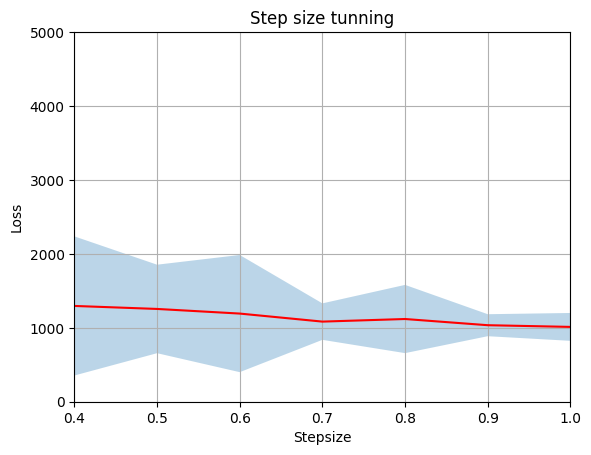

In [250]:
plt.title("Step size tunning")
plt.ylabel("Loss")
plt.xlabel("Stepsize")
plt.grid()

plt.plot(step_size_list ,loss_list, color="r")
plt.fill_between(step_size_list, np.array(loss_list)-np.array(loss_std), np.array(loss_list)+np.array(loss_std), alpha = 0.3)
plt.ylim(0, 5000)
plt.xlim(0.4, 1.0)
plt.show()

0
[1450.0519902236779, 1305.4963227871763, 22212.96698003255, 1115680.6420802372, 1206.7437117004697, 1076.8495049463913, 1201.02377047459, 1147.8276776587281, 1597.128760333014, 3741.4230560067595, 1281.4848303118442, 1.4355535809006326e+19, 8342.900235155212, 1426.9440671740135, 1272.161670335562, 1060.3415827788062, 2028.9928473464734, 1235.92393268607, 1278.229945949113, 1213.8133081819822, 1718.195570348966, 6495.458551412179, 1939.3248875928036, 1348.9975396122734, 280550.26720443735, 1157.6064846728807, 1055.8286474029505, 3417.184849940731, 1093.9350964246337, 1224.4015233195196, 1122.9709240500383, 3684.0725656741715, 1178.3010868565157, 14451.988914002797, 3475.7518347399036, 2421.4035412566286, 1181.3979890801256, 4260.52083230079, 59127.684149083376, 1207.117120744791, 1042.9708895934036, 1148.4912893064538, 1123.0751469615252, 2565.6528153464683, 1151.2532256734937, 1217.3831063939253, 3231.5594847704, 35108597841.790306, 1484.8626340127316, 36900.417620394765, 1576.323754

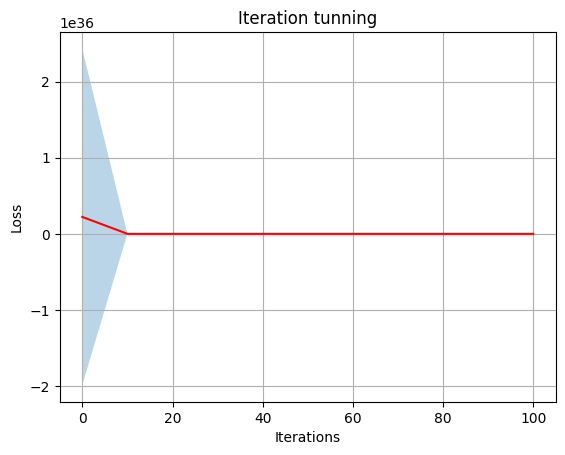

In [36]:
init_guess = []
for i in range(4):
    init_guess.append(random.uniform(0, 5))
  
init_guess = np.array(init_guess)
step_size = 0.8
data = df

n_runs = 99
loss_list = []
loss_std = []
iteration_list = []
for iterations in np.arange(0, 101, 10):
    print(iterations)
    mean_loss, std_loss, best_params = multirun_hill(n_runs, data, init_guess, step_size, iterations)
    loss_list.append(mean_loss)
    loss_std.append(std_loss)
    iteration_list.append(iterations)

plt.title("Iteration tunning")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.grid()

plt.plot(iteration_list, loss_list, color="r")
plt.fill_between(iteration_list, np.array(loss_list)-np.array(loss_std), np.array(loss_list)+np.array(loss_std), alpha = 0.3)

plt.show()

In [ ]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()
